In [1]:
import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = 'FNN-Classification-Simple'

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASH = getHash(name,[architecture,props])
print(HASH)

FNN-Classification-Simple-sigmoid_100000_1024_512_256_128_0001_CCE_10_1_0_0_1_0_e_e_0_1_0_basal_seg_data_norm_b25_roi_t1_native_k5_b25_t1_0_42_n_native_08_0_05_n


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(884582, 198)
(884582, 3)
validation
(154411, 198)
(154411, 3)
test
(115112, 198)
(115112, 3)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 198)]             0         


 dense (Dense)               (None, 1024)              203776    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 893187 (3.41 MB)


Trainable params: 893187 (3.41 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


1/9 [==>...........................] - ETA: 35s - loss: 1.5012 - STD: 0.2169 - MAE: 0.4534

2/9 [=====>........................] - ETA: 0s - loss: 1.3442 - STD: 0.1646 - MAE: 0.4510 

3/9 [=========>....................] - ETA: 0s - loss: 1.2546 - STD: 0.1279 - MAE: 0.4462

4/9 [============>.................] - ETA: 0s - loss: 1.2212 - STD: 0.1370 - MAE: 0.4407

5/9 [===============>..............] - ETA: 3s - loss: 1.2128 - STD: 0.1519 - MAE: 0.4363

6/9 [===================>..........] - ETA: 2s - loss: 1.2063 - STD: 0.1619 - MAE: 0.4335

7/9 [======================>.......] - ETA: 1s - loss: 1.1963 - STD: 0.1654 - MAE: 0.4316

8/9 [=========================>....] - ETA: 0s - loss: 1.1847 - STD: 0.1632 - MAE: 0.4308

9/9 [==============================] - ETA: 0s - loss: 1.1728 - STD: 0.1568 - MAE: 0.4307

9/9 [==============================] - 10s 699ms/step - loss: 1.1728 - STD: 0.1568 - MAE: 0.4307 - val_loss: 1.0730 - val_STD: 0.0708 - val_MAE: 0.4340


Epoch 2/10000


1/9 [==>...........................] - ETA: 1s - loss: 1.0728 - STD: 0.0708 - MAE: 0.4339

2/9 [=====>........................] - ETA: 0s - loss: 1.0762 - STD: 0.0636 - MAE: 0.4356

3/9 [=========>....................] - ETA: 0s - loss: 1.0811 - STD: 0.0623 - MAE: 0.4370

4/9 [============>.................] - ETA: 0s - loss: 1.0863 - STD: 0.0633 - MAE: 0.4380

5/9 [===============>..............] - ETA: 0s - loss: 1.0899 - STD: 0.0643 - MAE: 0.4387

6/9 [===================>..........] - ETA: 0s - loss: 1.0918 - STD: 0.0645 - MAE: 0.4391

7/9 [======================>.......] - ETA: 0s - loss: 1.0922 - STD: 0.0638 - MAE: 0.4393

8/9 [=========================>....] - ETA: 0s - loss: 1.0916 - STD: 0.0626 - MAE: 0.4393

9/9 [==============================] - ETA: 0s - loss: 1.0902 - STD: 0.0618 - MAE: 0.4391

9/9 [==============================] - 1s 115ms/step - loss: 1.0902 - STD: 0.0618 - MAE: 0.4391 - val_loss: 1.0737 - val_STD: 0.0630 - val_MAE: 0.4352


Epoch 3/10000


1/9 [==>...........................] - ETA: 1s - loss: 1.0745 - STD: 0.0629 - MAE: 0.4353

2/9 [=====>........................] - ETA: 0s - loss: 1.0738 - STD: 0.0696 - MAE: 0.4342

3/9 [=========>....................] - ETA: 0s - loss: 1.0743 - STD: 0.0766 - MAE: 0.4333

4/9 [============>.................] - ETA: 0s - loss: 1.0756 - STD: 0.0831 - MAE: 0.4325

5/9 [===============>..............] - ETA: 0s - loss: 1.0771 - STD: 0.0886 - MAE: 0.4318

6/9 [===================>..........] - ETA: 0s - loss: 1.0781 - STD: 0.0928 - MAE: 0.4313

7/9 [======================>.......] - ETA: 0s - loss: 1.0788 - STD: 0.0955 - MAE: 0.4309

8/9 [=========================>....] - ETA: 0s - loss: 1.0788 - STD: 0.0968 - MAE: 0.4307

9/9 [==============================] - ETA: 0s - loss: 1.0787 - STD: 0.0969 - MAE: 0.4307

9/9 [==============================] - 1s 118ms/step - loss: 1.0787 - STD: 0.0969 - MAE: 0.4307 - val_loss: 1.0743 - val_STD: 0.0871 - val_MAE: 0.4318


Epoch 4/10000


1/9 [==>...........................] - ETA: 1s - loss: 1.0736 - STD: 0.0871 - MAE: 0.4315

2/9 [=====>........................] - ETA: 0s - loss: 1.0734 - STD: 0.0823 - MAE: 0.4323

3/9 [=========>....................] - ETA: 0s - loss: 1.0733 - STD: 0.0779 - MAE: 0.4329

4/9 [============>.................] - ETA: 0s - loss: 1.0737 - STD: 0.0743 - MAE: 0.4335

5/9 [===============>..............] - ETA: 0s - loss: 1.0739 - STD: 0.0716 - MAE: 0.4340

6/9 [===================>..........] - ETA: 0s - loss: 1.0743 - STD: 0.0696 - MAE: 0.4343

7/9 [======================>.......] - ETA: 0s - loss: 1.0746 - STD: 0.0681 - MAE: 0.4346

8/9 [=========================>....] - ETA: 0s - loss: 1.0749 - STD: 0.0672 - MAE: 0.4348

9/9 [==============================] - ETA: 0s - loss: 1.0750 - STD: 0.0666 - MAE: 0.4349

9/9 [==============================] - 1s 115ms/step - loss: 1.0750 - STD: 0.0666 - MAE: 0.4349 - val_loss: 1.0743 - val_STD: 0.0632 - val_MAE: 0.4353


Epoch 5/10000


1/9 [==>...........................] - ETA: 1s - loss: 1.0751 - STD: 0.0632 - MAE: 0.4355

2/9 [=====>........................] - ETA: 0s - loss: 1.0746 - STD: 0.0645 - MAE: 0.4352

3/9 [=========>....................] - ETA: 0s - loss: 1.0739 - STD: 0.0661 - MAE: 0.4348

4/9 [============>.................] - ETA: 0s - loss: 1.0738 - STD: 0.0679 - MAE: 0.4345

5/9 [===============>..............] - ETA: 0s - loss: 1.0736 - STD: 0.0699 - MAE: 0.4342

6/9 [===================>..........] - ETA: 0s - loss: 1.0736 - STD: 0.0718 - MAE: 0.4339

7/9 [======================>.......] - ETA: 0s - loss: 1.0735 - STD: 0.0736 - MAE: 0.4336

8/9 [=========================>....] - ETA: 0s - loss: 1.0737 - STD: 0.0752 - MAE: 0.4334

9/9 [==============================] - ETA: 0s - loss: 1.0736 - STD: 0.0763 - MAE: 0.4332

9/9 [==============================] - 1s 115ms/step - loss: 1.0736 - STD: 0.0763 - MAE: 0.4332 - val_loss: 1.0732 - val_STD: 0.0842 - val_MAE: 0.4320


Epoch 6/10000


1/9 [==>...........................] - ETA: 1s - loss: 1.0750 - STD: 0.0842 - MAE: 0.4323

2/9 [=====>........................] - ETA: 0s - loss: 1.0744 - STD: 0.0827 - MAE: 0.4324

3/9 [=========>....................] - ETA: 0s - loss: 1.0741 - STD: 0.0810 - MAE: 0.4326

4/9 [============>.................] - ETA: 0s - loss: 1.0737 - STD: 0.0792 - MAE: 0.4328

5/9 [===============>..............] - ETA: 0s - loss: 1.0738 - STD: 0.0775 - MAE: 0.4331

6/9 [===================>..........] - ETA: 0s - loss: 1.0734 - STD: 0.0758 - MAE: 0.4333

7/9 [======================>.......] - ETA: 0s - loss: 1.0732 - STD: 0.0744 - MAE: 0.4334

8/9 [=========================>....] - ETA: 0s - loss: 1.0732 - STD: 0.0734 - MAE: 0.4336

9/9 [==============================] - ETA: 0s - loss: 1.0730 - STD: 0.0727 - MAE: 0.4336

9/9 [==============================] - 1s 122ms/step - loss: 1.0730 - STD: 0.0727 - MAE: 0.4336 - val_loss: 1.0724 - val_STD: 0.0687 - val_MAE: 0.4342


Epoch 7/10000


1/9 [==>...........................] - ETA: 1s - loss: 1.0734 - STD: 0.0687 - MAE: 0.4343

2/9 [=====>........................] - ETA: 0s - loss: 1.0728 - STD: 0.0694 - MAE: 0.4341

3/9 [=========>....................] - ETA: 0s - loss: 1.0724 - STD: 0.0701 - MAE: 0.4339

4/9 [============>.................] - ETA: 0s - loss: 1.0724 - STD: 0.0709 - MAE: 0.4338

5/9 [===============>..............] - ETA: 0s - loss: 1.0724 - STD: 0.0717 - MAE: 0.4336

6/9 [===================>..........] - ETA: 0s - loss: 1.0725 - STD: 0.0724 - MAE: 0.4336

7/9 [======================>.......] - ETA: 0s - loss: 1.0723 - STD: 0.0730 - MAE: 0.4334

8/9 [=========================>....] - ETA: 0s - loss: 1.0722 - STD: 0.0735 - MAE: 0.4333

9/9 [==============================] - ETA: 0s - loss: 1.0722 - STD: 0.0739 - MAE: 0.4333

9/9 [==============================] - 1s 122ms/step - loss: 1.0722 - STD: 0.0739 - MAE: 0.4333 - val_loss: 1.0713 - val_STD: 0.0776 - val_MAE: 0.4326


Epoch 8/10000


1/9 [==>...........................] - ETA: 1s - loss: 1.0717 - STD: 0.0776 - MAE: 0.4326

2/9 [=====>........................] - ETA: 0s - loss: 1.0717 - STD: 0.0774 - MAE: 0.4326

3/9 [=========>....................] - ETA: 0s - loss: 1.0717 - STD: 0.0770 - MAE: 0.4327

4/9 [============>.................] - ETA: 0s - loss: 1.0712 - STD: 0.0763 - MAE: 0.4327

5/9 [===============>..............] - ETA: 0s - loss: 1.0710 - STD: 0.0754 - MAE: 0.4328

6/9 [===================>..........] - ETA: 0s - loss: 1.0708 - STD: 0.0746 - MAE: 0.4329

7/9 [======================>.......] - ETA: 0s - loss: 1.0709 - STD: 0.0739 - MAE: 0.4330

8/9 [=========================>....] - ETA: 0s - loss: 1.0708 - STD: 0.0733 - MAE: 0.4330

9/9 [==============================] - ETA: 0s - loss: 1.0708 - STD: 0.0729 - MAE: 0.4331

9/9 [==============================] - 1s 122ms/step - loss: 1.0708 - STD: 0.0729 - MAE: 0.4331 - val_loss: 1.0693 - val_STD: 0.0707 - val_MAE: 0.4331


Epoch 9/10000


1/9 [==>...........................] - ETA: 1s - loss: 1.0687 - STD: 0.0706 - MAE: 0.4329

2/9 [=====>........................] - ETA: 0s - loss: 1.0689 - STD: 0.0714 - MAE: 0.4329

3/9 [=========>....................] - ETA: 0s - loss: 1.0689 - STD: 0.0723 - MAE: 0.4327

4/9 [============>.................] - ETA: 0s - loss: 1.0688 - STD: 0.0729 - MAE: 0.4326

5/9 [===============>..............] - ETA: 0s - loss: 1.0685 - STD: 0.0733 - MAE: 0.4325

6/9 [===================>..........] - ETA: 0s - loss: 1.0681 - STD: 0.0735 - MAE: 0.4323

7/9 [======================>.......] - ETA: 0s - loss: 1.0678 - STD: 0.0736 - MAE: 0.4322

8/9 [=========================>....] - ETA: 0s - loss: 1.0675 - STD: 0.0738 - MAE: 0.4321

9/9 [==============================] - ETA: 0s - loss: 1.0673 - STD: 0.0739 - MAE: 0.4321

9/9 [==============================] - 1s 119ms/step - loss: 1.0673 - STD: 0.0739 - MAE: 0.4321 - val_loss: 1.0637 - val_STD: 0.0746 - val_MAE: 0.4311


Epoch 10/10000


1/9 [==>...........................] - ETA: 1s - loss: 1.0634 - STD: 0.0743 - MAE: 0.4310

2/9 [=====>........................] - ETA: 0s - loss: 1.0633 - STD: 0.0741 - MAE: 0.4310

3/9 [=========>....................] - ETA: 0s - loss: 1.0627 - STD: 0.0738 - MAE: 0.4309

4/9 [============>.................] - ETA: 0s - loss: 1.0618 - STD: 0.0734 - MAE: 0.4307

5/9 [===============>..............] - ETA: 0s - loss: 1.0608 - STD: 0.0731 - MAE: 0.4305

6/9 [===================>..........] - ETA: 0s - loss: 1.0598 - STD: 0.0731 - MAE: 0.4303

7/9 [======================>.......] - ETA: 0s - loss: 1.0588 - STD: 0.0733 - MAE: 0.4300

8/9 [=========================>....] - ETA: 0s - loss: 1.0580 - STD: 0.0736 - MAE: 0.4297

9/9 [==============================] - ETA: 0s - loss: 1.0568 - STD: 0.0739 - MAE: 0.4293

9/9 [==============================] - 1s 124ms/step - loss: 1.0568 - STD: 0.0739 - MAE: 0.4293 - val_loss: 1.0462 - val_STD: 0.0776 - val_MAE: 0.4260


Epoch 11/10000


1/9 [==>...........................] - ETA: 1s - loss: 1.0433 - STD: 0.0769 - MAE: 0.4255

2/9 [=====>........................] - ETA: 0s - loss: 1.0420 - STD: 0.0776 - MAE: 0.4250

3/9 [=========>....................] - ETA: 0s - loss: 1.0401 - STD: 0.0785 - MAE: 0.4243

4/9 [============>.................] - ETA: 0s - loss: 1.0384 - STD: 0.0794 - MAE: 0.4236

5/9 [===============>..............] - ETA: 0s - loss: 1.0358 - STD: 0.0802 - MAE: 0.4229

6/9 [===================>..........] - ETA: 0s - loss: 1.0335 - STD: 0.0812 - MAE: 0.4221

7/9 [======================>.......] - ETA: 0s - loss: 1.0307 - STD: 0.0824 - MAE: 0.4212

8/9 [=========================>....] - ETA: 0s - loss: 1.0277 - STD: 0.0839 - MAE: 0.4201

9/9 [==============================] - ETA: 0s - loss: 1.0247 - STD: 0.0859 - MAE: 0.4190

9/9 [==============================] - 1s 119ms/step - loss: 1.0247 - STD: 0.0859 - MAE: 0.4190 - val_loss: 1.0025 - val_STD: 0.1077 - val_MAE: 0.4087


Epoch 12/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.9942 - STD: 0.1062 - MAE: 0.4071

2/9 [=====>........................] - ETA: 0s - loss: 0.9902 - STD: 0.1097 - MAE: 0.4054

3/9 [=========>....................] - ETA: 0s - loss: 0.9867 - STD: 0.1135 - MAE: 0.4036

4/9 [============>.................] - ETA: 0s - loss: 0.9831 - STD: 0.1175 - MAE: 0.4017

5/9 [===============>..............] - ETA: 0s - loss: 0.9799 - STD: 0.1211 - MAE: 0.3999

6/9 [===================>..........] - ETA: 0s - loss: 0.9766 - STD: 0.1246 - MAE: 0.3983

7/9 [======================>.......] - ETA: 0s - loss: 0.9730 - STD: 0.1282 - MAE: 0.3966

8/9 [=========================>....] - ETA: 0s - loss: 0.9695 - STD: 0.1318 - MAE: 0.3948

9/9 [==============================] - ETA: 0s - loss: 0.9665 - STD: 0.1352 - MAE: 0.3932

9/9 [==============================] - 1s 120ms/step - loss: 0.9665 - STD: 0.1352 - MAE: 0.3932 - val_loss: 0.9557 - val_STD: 0.1695 - val_MAE: 0.3812


Epoch 13/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.9326 - STD: 0.1686 - MAE: 0.3762

2/9 [=====>........................] - ETA: 0s - loss: 0.9318 - STD: 0.1709 - MAE: 0.3753

3/9 [=========>....................] - ETA: 0s - loss: 0.9296 - STD: 0.1725 - MAE: 0.3744

4/9 [============>.................] - ETA: 0s - loss: 0.9277 - STD: 0.1739 - MAE: 0.3735

5/9 [===============>..............] - ETA: 0s - loss: 0.9252 - STD: 0.1752 - MAE: 0.3726

6/9 [===================>..........] - ETA: 0s - loss: 0.9229 - STD: 0.1760 - MAE: 0.3719

7/9 [======================>.......] - ETA: 0s - loss: 0.9199 - STD: 0.1768 - MAE: 0.3710

8/9 [=========================>....] - ETA: 0s - loss: 0.9174 - STD: 0.1778 - MAE: 0.3702

9/9 [==============================] - ETA: 0s - loss: 0.9146 - STD: 0.1787 - MAE: 0.3693

9/9 [==============================] - 1s 119ms/step - loss: 0.9146 - STD: 0.1787 - MAE: 0.3693 - val_loss: 0.9187 - val_STD: 0.1939 - val_MAE: 0.3652


Epoch 14/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8890 - STD: 0.1900 - MAE: 0.3601

2/9 [=====>........................] - ETA: 0s - loss: 0.8871 - STD: 0.1933 - MAE: 0.3583

3/9 [=========>....................] - ETA: 0s - loss: 0.8861 - STD: 0.1937 - MAE: 0.3581

4/9 [============>.................] - ETA: 0s - loss: 0.8847 - STD: 0.1950 - MAE: 0.3573

5/9 [===============>..............] - ETA: 0s - loss: 0.8825 - STD: 0.1962 - MAE: 0.3563

6/9 [===================>..........] - ETA: 0s - loss: 0.8809 - STD: 0.1973 - MAE: 0.3556

7/9 [======================>.......] - ETA: 0s - loss: 0.8788 - STD: 0.1981 - MAE: 0.3548

8/9 [=========================>....] - ETA: 0s - loss: 0.8775 - STD: 0.1992 - MAE: 0.3541

9/9 [==============================] - ETA: 0s - loss: 0.8759 - STD: 0.1996 - MAE: 0.3536

9/9 [==============================] - 1s 119ms/step - loss: 0.8759 - STD: 0.1996 - MAE: 0.3536 - val_loss: 0.9028 - val_STD: 0.2289 - val_MAE: 0.3471


Epoch 15/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8675 - STD: 0.2257 - MAE: 0.3409

2/9 [=====>........................] - ETA: 0s - loss: 0.8648 - STD: 0.2147 - MAE: 0.3452

3/9 [=========>....................] - ETA: 0s - loss: 0.8621 - STD: 0.2138 - MAE: 0.3450

4/9 [============>.................] - ETA: 0s - loss: 0.8623 - STD: 0.2177 - MAE: 0.3434

5/9 [===============>..............] - ETA: 0s - loss: 0.8617 - STD: 0.2168 - MAE: 0.3437

6/9 [===================>..........] - ETA: 0s - loss: 0.8603 - STD: 0.2160 - MAE: 0.3438

7/9 [======================>.......] - ETA: 0s - loss: 0.8596 - STD: 0.2178 - MAE: 0.3429

8/9 [=========================>....] - ETA: 0s - loss: 0.8586 - STD: 0.2181 - MAE: 0.3426

9/9 [==============================] - ETA: 0s - loss: 0.8583 - STD: 0.2173 - MAE: 0.3429

9/9 [==============================] - 1s 120ms/step - loss: 0.8583 - STD: 0.2173 - MAE: 0.3429 - val_loss: 0.8865 - val_STD: 0.2305 - val_MAE: 0.3431


Epoch 16/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8469 - STD: 0.2255 - MAE: 0.3371

2/9 [=====>........................] - ETA: 0s - loss: 0.8485 - STD: 0.2288 - MAE: 0.3359

3/9 [=========>....................] - ETA: 0s - loss: 0.8478 - STD: 0.2258 - MAE: 0.3371

4/9 [============>.................] - ETA: 0s - loss: 0.8466 - STD: 0.2249 - MAE: 0.3373

5/9 [===============>..............] - ETA: 0s - loss: 0.8471 - STD: 0.2270 - MAE: 0.3364

6/9 [===================>..........] - ETA: 0s - loss: 0.8468 - STD: 0.2277 - MAE: 0.3361

7/9 [======================>.......] - ETA: 0s - loss: 0.8462 - STD: 0.2268 - MAE: 0.3364

8/9 [=========================>....] - ETA: 0s - loss: 0.8459 - STD: 0.2269 - MAE: 0.3363

9/9 [==============================] - ETA: 0s - loss: 0.8457 - STD: 0.2278 - MAE: 0.3359

9/9 [==============================] - 1s 121ms/step - loss: 0.8457 - STD: 0.2278 - MAE: 0.3359 - val_loss: 0.8797 - val_STD: 0.2325 - val_MAE: 0.3410


Epoch 17/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8385 - STD: 0.2255 - MAE: 0.3354

2/9 [=====>........................] - ETA: 0s - loss: 0.8382 - STD: 0.2266 - MAE: 0.3349

3/9 [=========>....................] - ETA: 0s - loss: 0.8399 - STD: 0.2299 - MAE: 0.3338

4/9 [============>.................] - ETA: 0s - loss: 0.8389 - STD: 0.2308 - MAE: 0.3332

5/9 [===============>..............] - ETA: 0s - loss: 0.8389 - STD: 0.2309 - MAE: 0.3332

6/9 [===================>..........] - ETA: 0s - loss: 0.8386 - STD: 0.2318 - MAE: 0.3327

7/9 [======================>.......] - ETA: 0s - loss: 0.8381 - STD: 0.2323 - MAE: 0.3324

8/9 [=========================>....] - ETA: 0s - loss: 0.8380 - STD: 0.2321 - MAE: 0.3325

9/9 [==============================] - ETA: 0s - loss: 0.8378 - STD: 0.2323 - MAE: 0.3324

9/9 [==============================] - 1s 127ms/step - loss: 0.8378 - STD: 0.2323 - MAE: 0.3324 - val_loss: 0.8747 - val_STD: 0.2447 - val_MAE: 0.3342


Epoch 18/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8355 - STD: 0.2375 - MAE: 0.3295

2/9 [=====>........................] - ETA: 0s - loss: 0.8354 - STD: 0.2372 - MAE: 0.3297

3/9 [=========>....................] - ETA: 0s - loss: 0.8346 - STD: 0.2359 - MAE: 0.3301

4/9 [============>.................] - ETA: 0s - loss: 0.8344 - STD: 0.2374 - MAE: 0.3294

5/9 [===============>..............] - ETA: 0s - loss: 0.8342 - STD: 0.2368 - MAE: 0.3296

6/9 [===================>..........] - ETA: 0s - loss: 0.8335 - STD: 0.2362 - MAE: 0.3297

7/9 [======================>.......] - ETA: 0s - loss: 0.8332 - STD: 0.2369 - MAE: 0.3294

8/9 [=========================>....] - ETA: 0s - loss: 0.8327 - STD: 0.2369 - MAE: 0.3293

9/9 [==============================] - ETA: 0s - loss: 0.8326 - STD: 0.2369 - MAE: 0.3293

9/9 [==============================] - 1s 123ms/step - loss: 0.8326 - STD: 0.2369 - MAE: 0.3293 - val_loss: 0.8709 - val_STD: 0.2507 - val_MAE: 0.3306


Epoch 19/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8304 - STD: 0.2433 - MAE: 0.3258

2/9 [=====>........................] - ETA: 0s - loss: 0.8310 - STD: 0.2415 - MAE: 0.3268

3/9 [=========>....................] - ETA: 0s - loss: 0.8301 - STD: 0.2398 - MAE: 0.3274

4/9 [============>.................] - ETA: 0s - loss: 0.8299 - STD: 0.2397 - MAE: 0.3274

5/9 [===============>..............] - ETA: 0s - loss: 0.8293 - STD: 0.2393 - MAE: 0.3275

6/9 [===================>..........] - ETA: 0s - loss: 0.8285 - STD: 0.2392 - MAE: 0.3274

7/9 [======================>.......] - ETA: 0s - loss: 0.8284 - STD: 0.2398 - MAE: 0.3271

8/9 [=========================>....] - ETA: 0s - loss: 0.8280 - STD: 0.2399 - MAE: 0.3269

9/9 [==============================] - ETA: 0s - loss: 0.8278 - STD: 0.2400 - MAE: 0.3269

9/9 [==============================] - 1s 129ms/step - loss: 0.8278 - STD: 0.2400 - MAE: 0.3269 - val_loss: 0.8661 - val_STD: 0.2503 - val_MAE: 0.3297


Epoch 20/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8249 - STD: 0.2427 - MAE: 0.3250

2/9 [=====>........................] - ETA: 0s - loss: 0.8251 - STD: 0.2417 - MAE: 0.3255

3/9 [=========>....................] - ETA: 0s - loss: 0.8254 - STD: 0.2418 - MAE: 0.3255

4/9 [============>.................] - ETA: 0s - loss: 0.8246 - STD: 0.2426 - MAE: 0.3250

5/9 [===============>..............] - ETA: 0s - loss: 0.8236 - STD: 0.2418 - MAE: 0.3252

6/9 [===================>..........] - ETA: 0s - loss: 0.8235 - STD: 0.2426 - MAE: 0.3248

7/9 [======================>.......] - ETA: 0s - loss: 0.8233 - STD: 0.2421 - MAE: 0.3249

8/9 [=========================>....] - ETA: 0s - loss: 0.8228 - STD: 0.2420 - MAE: 0.3249

9/9 [==============================] - ETA: 0s - loss: 0.8229 - STD: 0.2424 - MAE: 0.3247

9/9 [==============================] - 1s 122ms/step - loss: 0.8229 - STD: 0.2424 - MAE: 0.3247 - val_loss: 0.8620 - val_STD: 0.2456 - val_MAE: 0.3313


Epoch 21/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8180 - STD: 0.2385 - MAE: 0.3255

2/9 [=====>........................] - ETA: 0s - loss: 0.8192 - STD: 0.2434 - MAE: 0.3234

3/9 [=========>....................] - ETA: 0s - loss: 0.8199 - STD: 0.2424 - MAE: 0.3241

4/9 [============>.................] - ETA: 0s - loss: 0.8200 - STD: 0.2423 - MAE: 0.3242

5/9 [===============>..............] - ETA: 0s - loss: 0.8194 - STD: 0.2436 - MAE: 0.3234

6/9 [===================>..........] - ETA: 0s - loss: 0.8189 - STD: 0.2429 - MAE: 0.3236

7/9 [======================>.......] - ETA: 0s - loss: 0.8186 - STD: 0.2446 - MAE: 0.3228

8/9 [=========================>....] - ETA: 0s - loss: 0.8183 - STD: 0.2442 - MAE: 0.3229

9/9 [==============================] - ETA: 0s - loss: 0.8175 - STD: 0.2440 - MAE: 0.3228

9/9 [==============================] - 1s 120ms/step - loss: 0.8175 - STD: 0.2440 - MAE: 0.3228 - val_loss: 0.8571 - val_STD: 0.2542 - val_MAE: 0.3260


Epoch 22/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8133 - STD: 0.2484 - MAE: 0.3199

2/9 [=====>........................] - ETA: 0s - loss: 0.8121 - STD: 0.2459 - MAE: 0.3208

3/9 [=========>....................] - ETA: 0s - loss: 0.8113 - STD: 0.2471 - MAE: 0.3200

4/9 [============>.................] - ETA: 0s - loss: 0.8111 - STD: 0.2466 - MAE: 0.3202

5/9 [===============>..............] - ETA: 0s - loss: 0.8111 - STD: 0.2459 - MAE: 0.3205

6/9 [===================>..........] - ETA: 0s - loss: 0.8116 - STD: 0.2472 - MAE: 0.3200

7/9 [======================>.......] - ETA: 0s - loss: 0.8113 - STD: 0.2466 - MAE: 0.3203

8/9 [=========================>....] - ETA: 0s - loss: 0.8107 - STD: 0.2469 - MAE: 0.3199

9/9 [==============================] - ETA: 0s - loss: 0.8098 - STD: 0.2473 - MAE: 0.3196

9/9 [==============================] - 1s 120ms/step - loss: 0.8098 - STD: 0.2473 - MAE: 0.3196 - val_loss: 0.8551 - val_STD: 0.2518 - val_MAE: 0.3267


Epoch 23/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8065 - STD: 0.2467 - MAE: 0.3192

2/9 [=====>........................] - ETA: 0s - loss: 0.8090 - STD: 0.2503 - MAE: 0.3179

3/9 [=========>....................] - ETA: 0s - loss: 0.8073 - STD: 0.2486 - MAE: 0.3183

4/9 [============>.................] - ETA: 0s - loss: 0.8056 - STD: 0.2497 - MAE: 0.3175

5/9 [===============>..............] - ETA: 0s - loss: 0.8050 - STD: 0.2500 - MAE: 0.3172

6/9 [===================>..........] - ETA: 0s - loss: 0.8043 - STD: 0.2495 - MAE: 0.3173

7/9 [======================>.......] - ETA: 0s - loss: 0.8040 - STD: 0.2499 - MAE: 0.3170

8/9 [=========================>....] - ETA: 0s - loss: 0.8034 - STD: 0.2504 - MAE: 0.3166

9/9 [==============================] - ETA: 0s - loss: 0.8031 - STD: 0.2505 - MAE: 0.3165

9/9 [==============================] - 1s 117ms/step - loss: 0.8031 - STD: 0.2505 - MAE: 0.3165 - val_loss: 0.8531 - val_STD: 0.2592 - val_MAE: 0.3223


Epoch 24/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7965 - STD: 0.2532 - MAE: 0.3137

2/9 [=====>........................] - ETA: 0s - loss: 0.7977 - STD: 0.2525 - MAE: 0.3143

3/9 [=========>....................] - ETA: 0s - loss: 0.7979 - STD: 0.2534 - MAE: 0.3139

4/9 [============>.................] - ETA: 0s - loss: 0.7976 - STD: 0.2533 - MAE: 0.3139

5/9 [===============>..............] - ETA: 0s - loss: 0.7971 - STD: 0.2535 - MAE: 0.3137

6/9 [===================>..........] - ETA: 0s - loss: 0.7967 - STD: 0.2536 - MAE: 0.3136

7/9 [======================>.......] - ETA: 0s - loss: 0.7967 - STD: 0.2537 - MAE: 0.3135

8/9 [=========================>....] - ETA: 0s - loss: 0.7971 - STD: 0.2540 - MAE: 0.3135

9/9 [==============================] - ETA: 0s - loss: 0.7963 - STD: 0.2540 - MAE: 0.3133

9/9 [==============================] - 1s 121ms/step - loss: 0.7963 - STD: 0.2540 - MAE: 0.3133 - val_loss: 0.8514 - val_STD: 0.2626 - val_MAE: 0.3199


Epoch 25/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7919 - STD: 0.2545 - MAE: 0.3121

2/9 [=====>........................] - ETA: 0s - loss: 0.7934 - STD: 0.2560 - MAE: 0.3116

3/9 [=========>....................] - ETA: 0s - loss: 0.7930 - STD: 0.2561 - MAE: 0.3115

4/9 [============>.................] - ETA: 0s - loss: 0.7927 - STD: 0.2567 - MAE: 0.3111

5/9 [===============>..............] - ETA: 0s - loss: 0.7928 - STD: 0.2565 - MAE: 0.3112

6/9 [===================>..........] - ETA: 0s - loss: 0.7928 - STD: 0.2563 - MAE: 0.3113

7/9 [======================>.......] - ETA: 0s - loss: 0.7920 - STD: 0.2566 - MAE: 0.3110

8/9 [=========================>....] - ETA: 0s - loss: 0.7917 - STD: 0.2568 - MAE: 0.3109

9/9 [==============================] - ETA: 0s - loss: 0.7917 - STD: 0.2567 - MAE: 0.3109

9/9 [==============================] - 1s 119ms/step - loss: 0.7917 - STD: 0.2567 - MAE: 0.3109 - val_loss: 0.8503 - val_STD: 0.2663 - val_MAE: 0.3176


Epoch 26/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7876 - STD: 0.2564 - MAE: 0.3101

2/9 [=====>........................] - ETA: 0s - loss: 0.7882 - STD: 0.2583 - MAE: 0.3093

3/9 [=========>....................] - ETA: 0s - loss: 0.7883 - STD: 0.2575 - MAE: 0.3097

4/9 [============>.................] - ETA: 0s - loss: 0.7878 - STD: 0.2575 - MAE: 0.3096

5/9 [===============>..............] - ETA: 0s - loss: 0.7879 - STD: 0.2588 - MAE: 0.3090

6/9 [===================>..........] - ETA: 0s - loss: 0.7889 - STD: 0.2589 - MAE: 0.3091

7/9 [======================>.......] - ETA: 0s - loss: 0.7902 - STD: 0.2589 - MAE: 0.3094

8/9 [=========================>....] - ETA: 0s - loss: 0.7901 - STD: 0.2590 - MAE: 0.3093

9/9 [==============================] - ETA: 0s - loss: 0.7896 - STD: 0.2592 - MAE: 0.3092

9/9 [==============================] - 1s 123ms/step - loss: 0.7896 - STD: 0.2592 - MAE: 0.3092 - val_loss: 0.8499 - val_STD: 0.2689 - val_MAE: 0.3161


Epoch 27/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7885 - STD: 0.2573 - MAE: 0.3099

2/9 [=====>........................] - ETA: 0s - loss: 0.7867 - STD: 0.2570 - MAE: 0.3096

3/9 [=========>....................] - ETA: 0s - loss: 0.7870 - STD: 0.2586 - MAE: 0.3089

4/9 [============>.................] - ETA: 0s - loss: 0.7868 - STD: 0.2589 - MAE: 0.3087

5/9 [===============>..............] - ETA: 0s - loss: 0.7864 - STD: 0.2586 - MAE: 0.3088

6/9 [===================>..........] - ETA: 0s - loss: 0.7862 - STD: 0.2588 - MAE: 0.3086

7/9 [======================>.......] - ETA: 0s - loss: 0.7857 - STD: 0.2594 - MAE: 0.3082

8/9 [=========================>....] - ETA: 0s - loss: 0.7856 - STD: 0.2593 - MAE: 0.3083

9/9 [==============================] - ETA: 0s - loss: 0.7855 - STD: 0.2592 - MAE: 0.3083

9/9 [==============================] - 1s 126ms/step - loss: 0.7855 - STD: 0.2592 - MAE: 0.3083 - val_loss: 0.8495 - val_STD: 0.2718 - val_MAE: 0.3142


Epoch 28/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7857 - STD: 0.2612 - MAE: 0.3073

2/9 [=====>........................] - ETA: 0s - loss: 0.7833 - STD: 0.2611 - MAE: 0.3068

3/9 [=========>....................] - ETA: 0s - loss: 0.7838 - STD: 0.2604 - MAE: 0.3073

4/9 [============>.................] - ETA: 0s - loss: 0.7848 - STD: 0.2603 - MAE: 0.3076

5/9 [===============>..............] - ETA: 0s - loss: 0.7850 - STD: 0.2611 - MAE: 0.3072

6/9 [===================>..........] - ETA: 0s - loss: 0.7839 - STD: 0.2609 - MAE: 0.3071

7/9 [======================>.......] - ETA: 0s - loss: 0.7833 - STD: 0.2610 - MAE: 0.3070

8/9 [=========================>....] - ETA: 0s - loss: 0.7831 - STD: 0.2614 - MAE: 0.3067

9/9 [==============================] - ETA: 0s - loss: 0.7831 - STD: 0.2615 - MAE: 0.3067

9/9 [==============================] - 1s 123ms/step - loss: 0.7831 - STD: 0.2615 - MAE: 0.3067 - val_loss: 0.8470 - val_STD: 0.2726 - val_MAE: 0.3134


Epoch 29/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7791 - STD: 0.2626 - MAE: 0.3052

2/9 [=====>........................] - ETA: 0s - loss: 0.7779 - STD: 0.2632 - MAE: 0.3047

3/9 [=========>....................] - ETA: 0s - loss: 0.7803 - STD: 0.2620 - MAE: 0.3059

4/9 [============>.................] - ETA: 0s - loss: 0.7814 - STD: 0.2617 - MAE: 0.3062

5/9 [===============>..............] - ETA: 0s - loss: 0.7816 - STD: 0.2617 - MAE: 0.3062

6/9 [===================>..........] - ETA: 0s - loss: 0.7810 - STD: 0.2617 - MAE: 0.3061

7/9 [======================>.......] - ETA: 0s - loss: 0.7804 - STD: 0.2615 - MAE: 0.3061

8/9 [=========================>....] - ETA: 0s - loss: 0.7803 - STD: 0.2618 - MAE: 0.3060

9/9 [==============================] - ETA: 0s - loss: 0.7802 - STD: 0.2621 - MAE: 0.3058

9/9 [==============================] - 1s 121ms/step - loss: 0.7802 - STD: 0.2621 - MAE: 0.3058 - val_loss: 0.8456 - val_STD: 0.2715 - val_MAE: 0.3137


Epoch 30/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7798 - STD: 0.2607 - MAE: 0.3065

2/9 [=====>........................] - ETA: 0s - loss: 0.7785 - STD: 0.2624 - MAE: 0.3053

3/9 [=========>....................] - ETA: 0s - loss: 0.7784 - STD: 0.2641 - MAE: 0.3044

4/9 [============>.................] - ETA: 0s - loss: 0.7782 - STD: 0.2634 - MAE: 0.3047

5/9 [===============>..............] - ETA: 0s - loss: 0.7777 - STD: 0.2629 - MAE: 0.3049

6/9 [===================>..........] - ETA: 0s - loss: 0.7776 - STD: 0.2636 - MAE: 0.3045

7/9 [======================>.......] - ETA: 0s - loss: 0.7777 - STD: 0.2634 - MAE: 0.3046

8/9 [=========================>....] - ETA: 0s - loss: 0.7776 - STD: 0.2629 - MAE: 0.3049

9/9 [==============================] - ETA: 0s - loss: 0.7778 - STD: 0.2632 - MAE: 0.3048

9/9 [==============================] - 1s 120ms/step - loss: 0.7778 - STD: 0.2632 - MAE: 0.3048 - val_loss: 0.8453 - val_STD: 0.2754 - val_MAE: 0.3114


Epoch 31/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7757 - STD: 0.2654 - MAE: 0.3032

2/9 [=====>........................] - ETA: 0s - loss: 0.7780 - STD: 0.2644 - MAE: 0.3042

3/9 [=========>....................] - ETA: 0s - loss: 0.7788 - STD: 0.2639 - MAE: 0.3047

4/9 [============>.................] - ETA: 0s - loss: 0.7781 - STD: 0.2642 - MAE: 0.3043

5/9 [===============>..............] - ETA: 0s - loss: 0.7779 - STD: 0.2640 - MAE: 0.3044

6/9 [===================>..........] - ETA: 0s - loss: 0.7774 - STD: 0.2639 - MAE: 0.3043

7/9 [======================>.......] - ETA: 0s - loss: 0.7768 - STD: 0.2638 - MAE: 0.3043

8/9 [=========================>....] - ETA: 0s - loss: 0.7762 - STD: 0.2638 - MAE: 0.3041

9/9 [==============================] - ETA: 0s - loss: 0.7756 - STD: 0.2639 - MAE: 0.3040

9/9 [==============================] - 1s 121ms/step - loss: 0.7756 - STD: 0.2639 - MAE: 0.3040 - val_loss: 0.8416 - val_STD: 0.2754 - val_MAE: 0.3108


Epoch 32/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7741 - STD: 0.2650 - MAE: 0.3031

2/9 [=====>........................] - ETA: 0s - loss: 0.7736 - STD: 0.2645 - MAE: 0.3032

3/9 [=========>....................] - ETA: 0s - loss: 0.7733 - STD: 0.2649 - MAE: 0.3030

4/9 [============>.................] - ETA: 0s - loss: 0.7734 - STD: 0.2651 - MAE: 0.3029

5/9 [===============>..............] - ETA: 0s - loss: 0.7735 - STD: 0.2653 - MAE: 0.3028

6/9 [===================>..........] - ETA: 0s - loss: 0.7737 - STD: 0.2650 - MAE: 0.3030

7/9 [======================>.......] - ETA: 0s - loss: 0.7736 - STD: 0.2649 - MAE: 0.3030

8/9 [=========================>....] - ETA: 0s - loss: 0.7730 - STD: 0.2651 - MAE: 0.3028

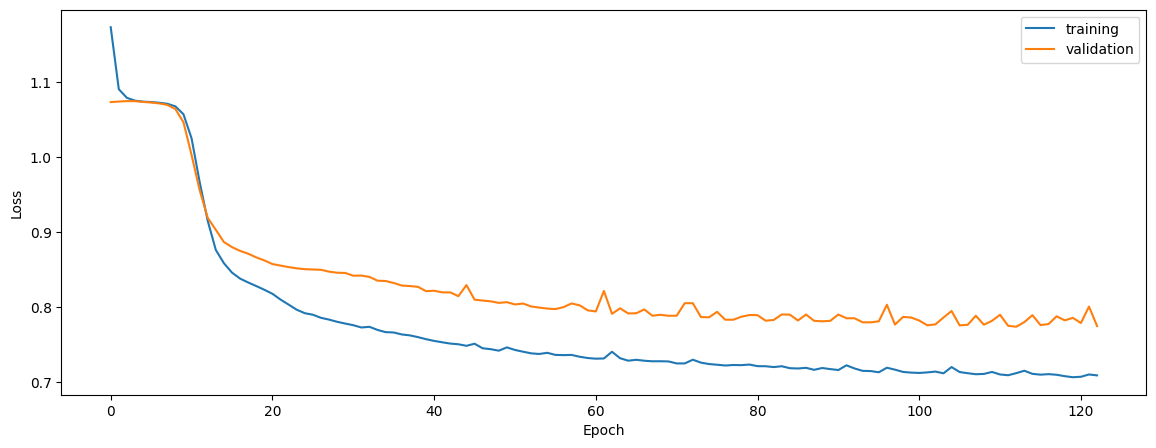

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.6845255725303024


0.663761001483055


0.6724494405448607


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.7160349283885042


0.6784035959953688


0.7022159706689418


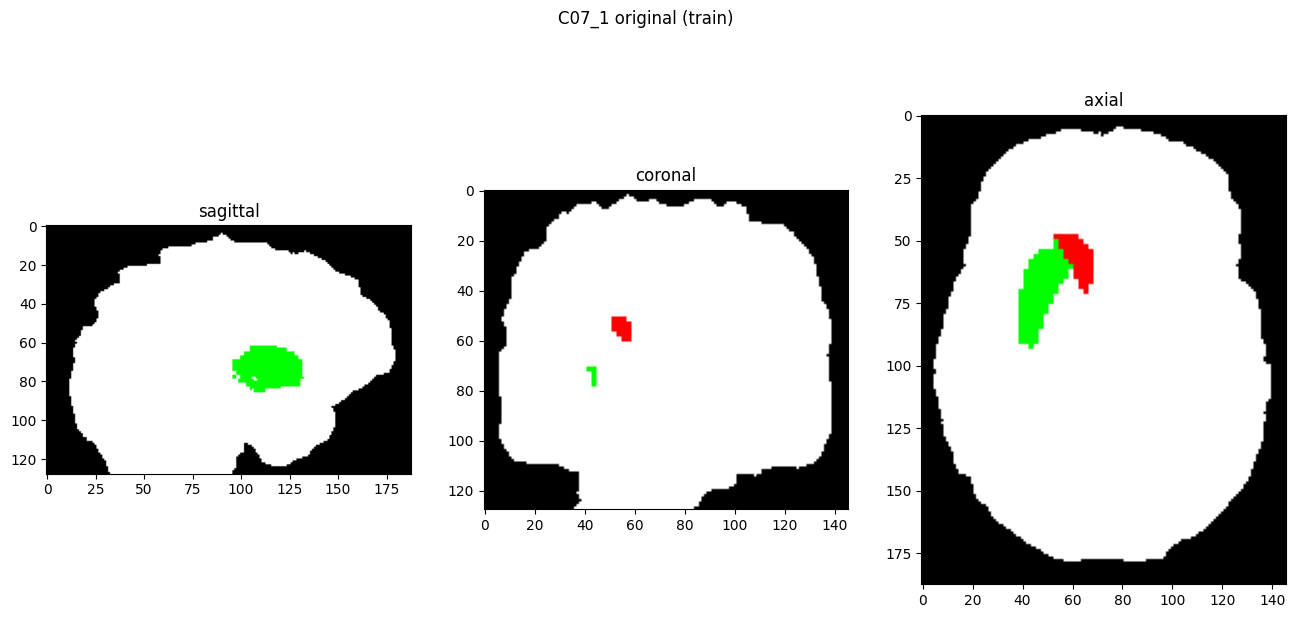

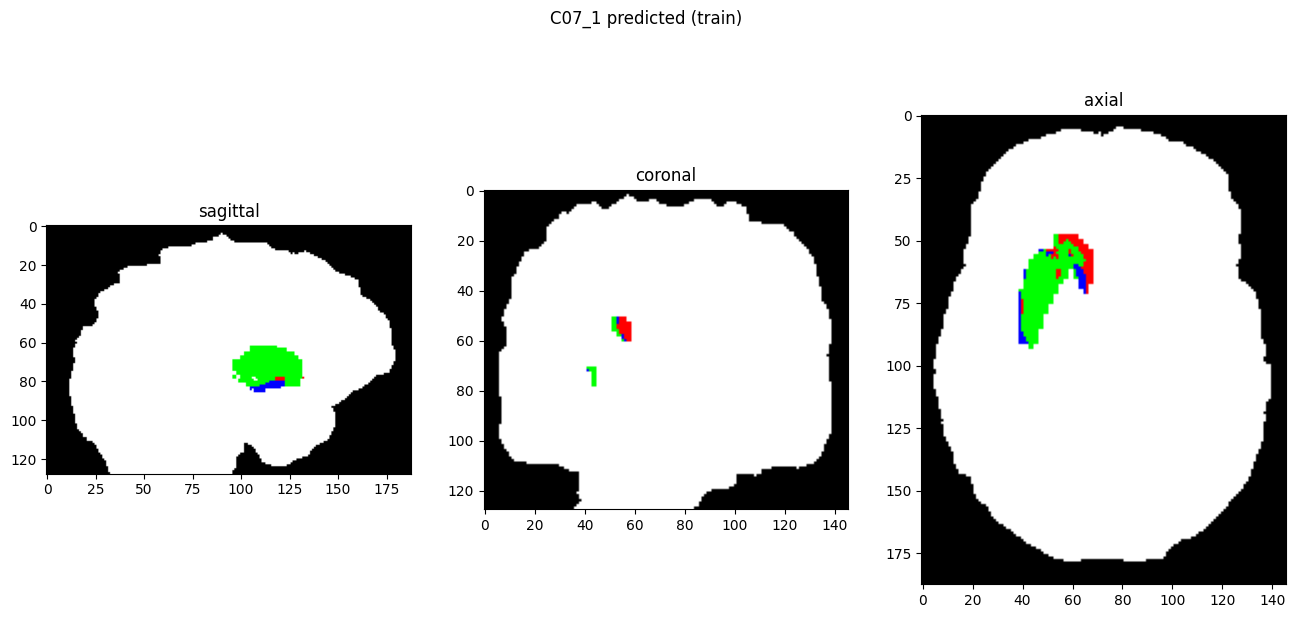

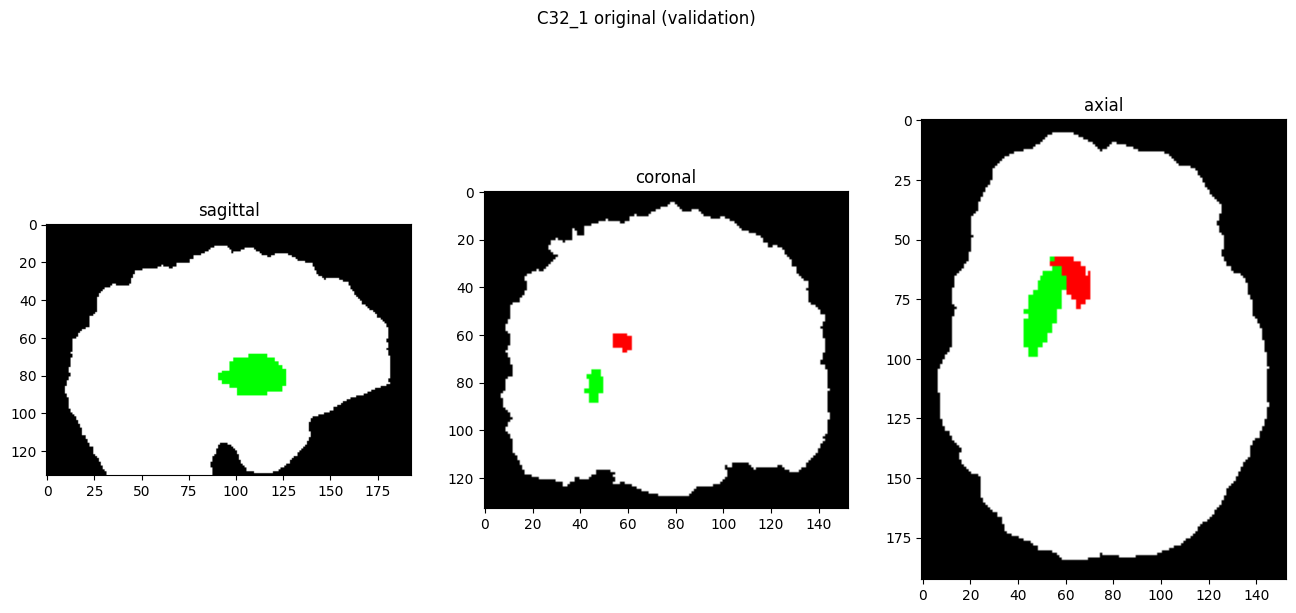

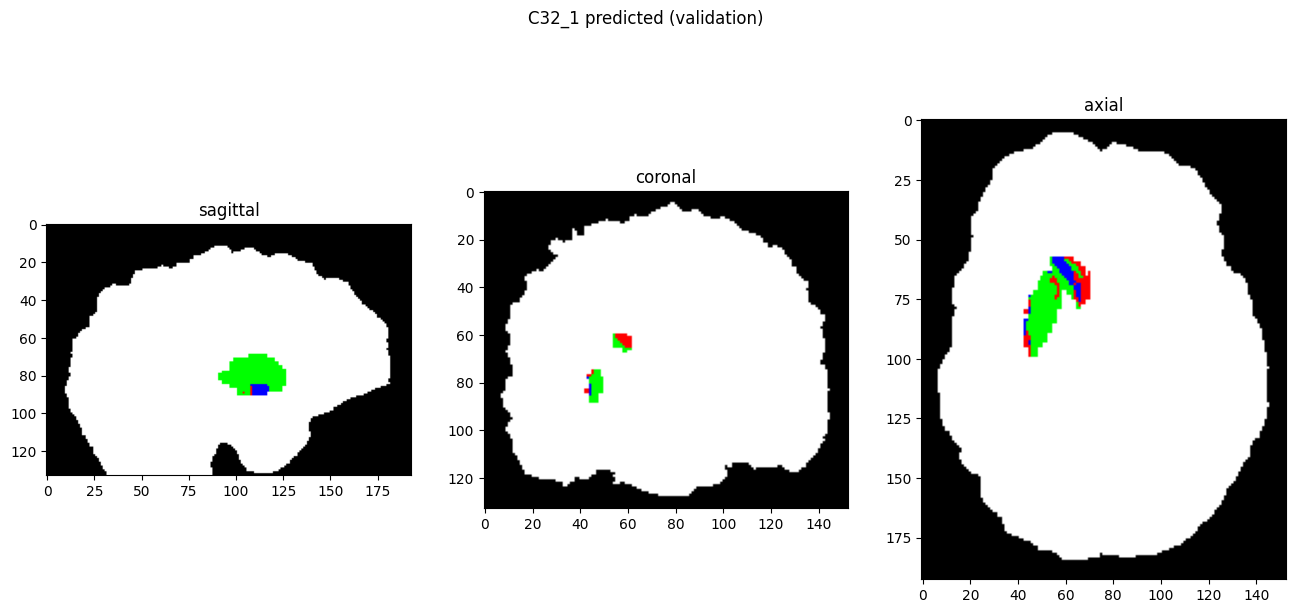

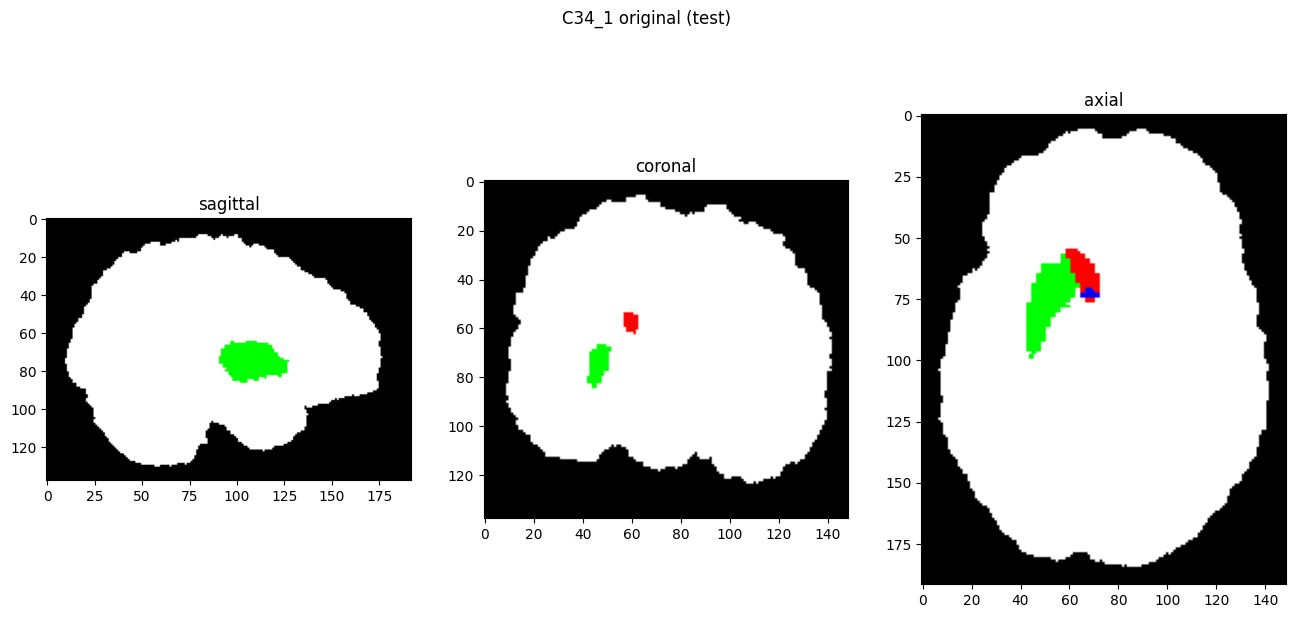

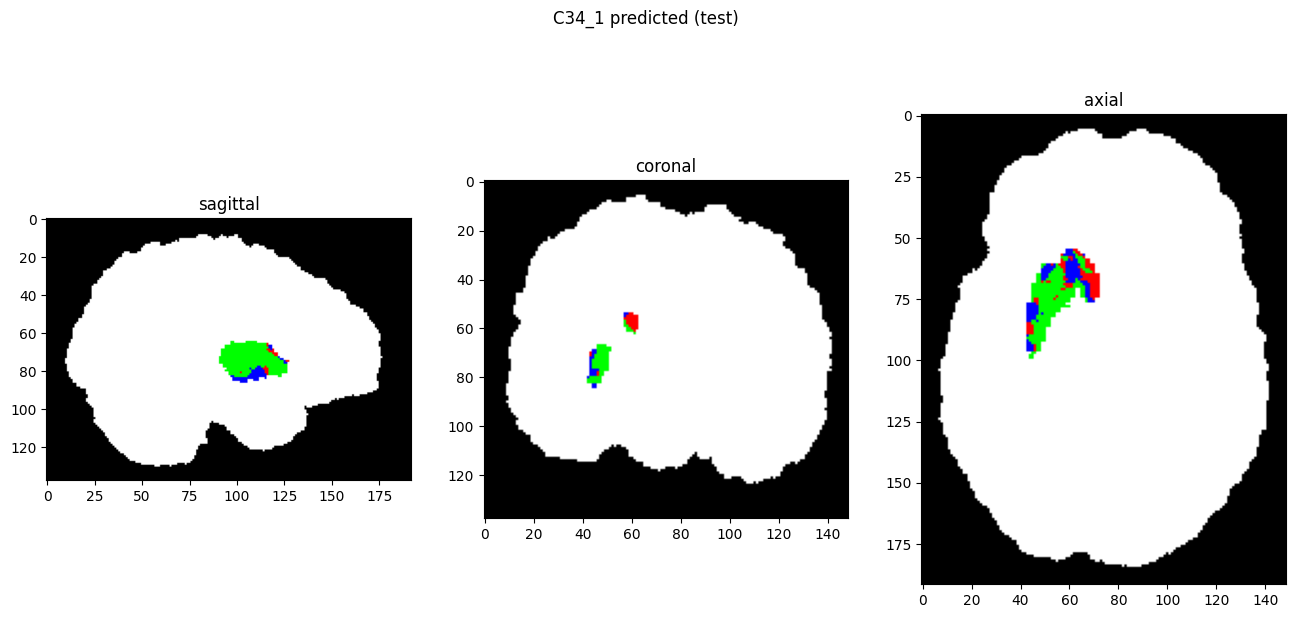

In [9]:
showResults(model, gen, threshold=0)